In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [4]:

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [5]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [7]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [11]:
class Meso4FineTune(Meso4):
    def __init__(self, learning_rate=0.0001):
        super().__init__(learning_rate)
        self.fine_tune_lr = learning_rate / 10
        
    def fine_tune(self, generator, fine_tune_epochs=1):
        # Unfreeze some layers for fine-tuning
        for layer in self.model.layers:
            layer.trainable = True
        
        # Lower learning rate for fine-tuning
        optimizer = Adam(lr=self.fine_tune_lr)
        self.model.compile(optimizer=optimizer,
                           loss='mean_squared_error',
                           metrics=['accuracy'])
        
        # Fine-tune the model
        self.model.fit(generator,
                       epochs=fine_tune_epochs,
                       verbose=1)
        print("Fine-tuning completed.")

In [9]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [10]:
dataGenerator = ImageDataGenerator(rescale=1./255)
# Splitting data into training and test sets

train_generator = dataGenerator.flow_from_directory(
    './data/train/',
    target_size=(256, 256),
    batch_size=1,  # Adjust batch size as needed
    class_mode='binary'
)

test_generator = dataGenerator.flow_from_directory(
    './data/test',
    target_size=(256, 256),
    batch_size=1,  # Adjust batch size as needed
    class_mode='binary'
)

# Fine-tuning the model
meso_fine_tune = Meso4FineTune()
meso_fine_tune.fine_tune(train_generator, fine_tune_epochs=1)

# Evaluating accuracy on the test set
test_loss, test_accuracy = meso_fine_tune.model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 5710 images belonging to 2 classes.
Found 1394 images belonging to 2 classes.


5710/5710 [==============================] - 292s 51ms/step - loss: 0.1420 - accuracy: 0.8210
Fine-tuning completed.
1394/1394 [==============================] - 21s 14ms/step - loss: 0.1376 - accuracy: 0.8386
Test Loss: 0.13763298094272614
Test Accuracy: 0.8385939598083496


In [14]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [17]:
# Generating predictions on validation set, storing in separate lists
generator = test_generator
for i in range(1000):
    
    # Loading next picture, generating prediction
    X, y = test_generator.next()
    pred = meso.predict(X)[0][0]
    print(y)
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 100 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 20ms/step
[1.]
0  predictions completed.
1/1 [==============================] - 0s 21ms/step
[0.]
1/1 [==============================] - 0s 20ms/step
[1.]
1/1 [==============================] - 0s 20ms/step
[0.]
1/1 [==============================] - 0s 20ms/step
[1.]
1/1 [==============================] - 0s 21ms/step
[1.]
1/1 [==============================] - 0s 20ms/step
[0.]
1/1 [==============================] - 0s 20ms/step
[1.]
1/1 [==============================] - 0s 20ms/step
[0.]
1/1 [==============================] - 0s 21ms/step
[1.]
1/1 [==============================] - 0s 21ms/step
[1.]
1/1 [==============================] - 0s 24ms/step
[0.]
1/1 [==============================] - 0s 21ms/step
[1.]
1/1 [==============================] - 0s 25ms/step
[1.]
1/1 [==============================] - 0s 31ms/step
[1.]
1/1 [==============================] - 0s 27ms/step
[1.]
1/1 [==============================] - 0s 22ms/step
[0.]
1/1 [

In [18]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show
    return

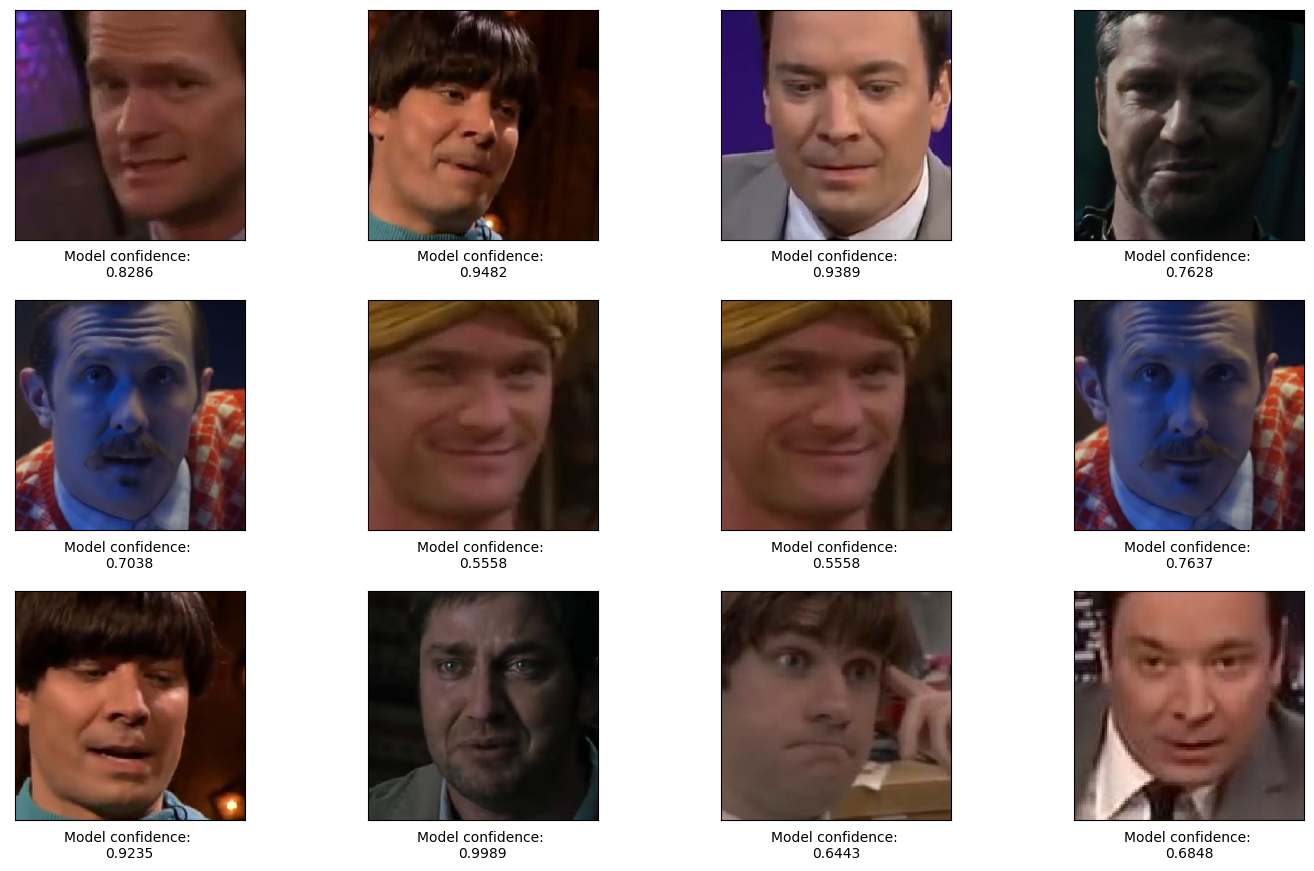

In [19]:
plotter(correct_real, correct_real_pred)